Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10


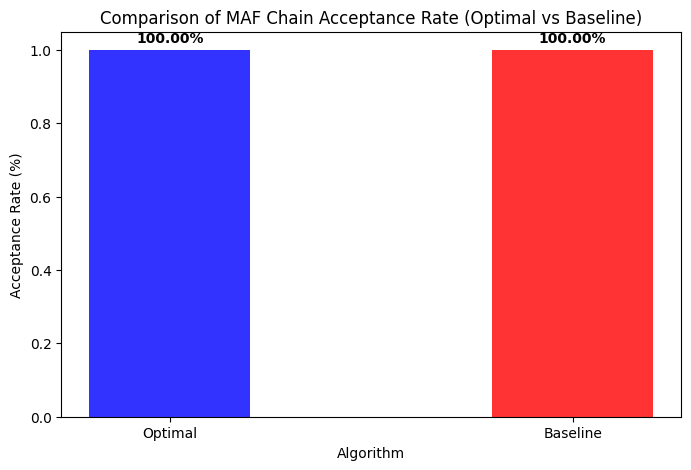

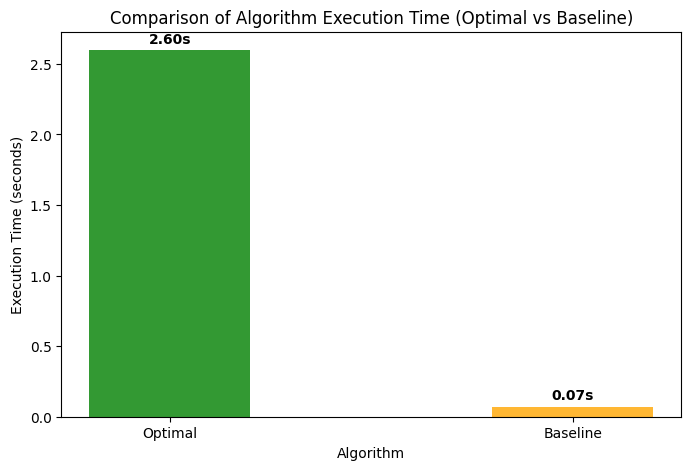

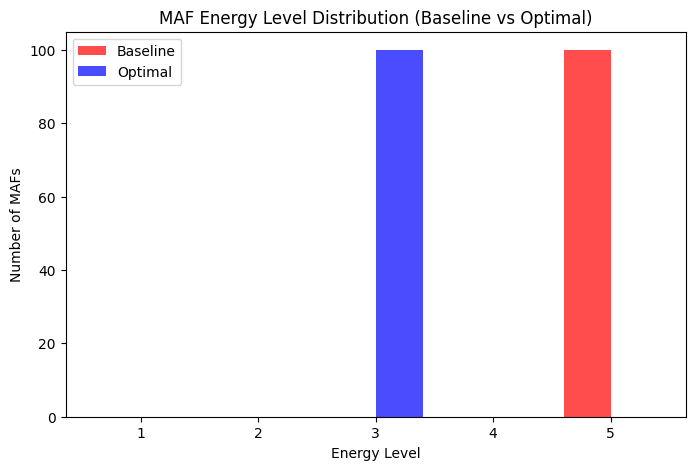

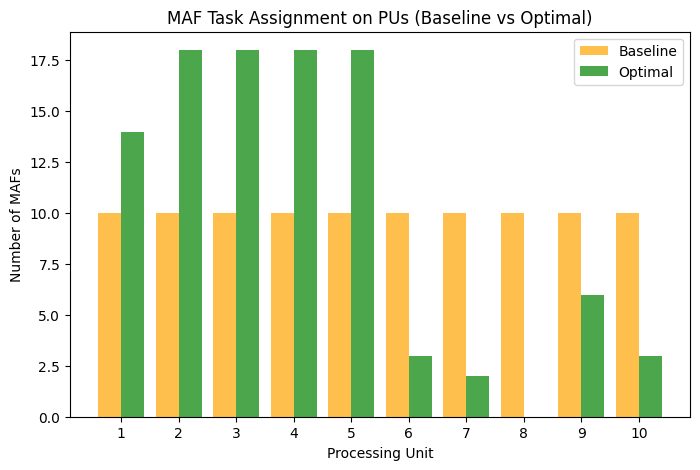

✅ Optimal Model Objective: 85560.00
✅ Baseline Model Objective: 84240.00


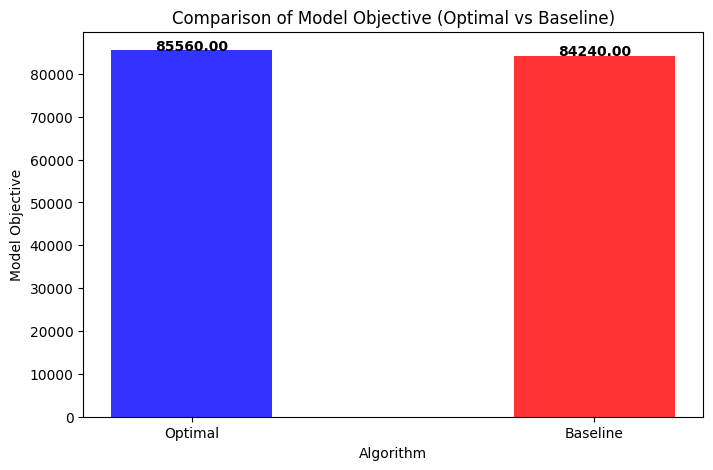

Testing with α1=1000, α2=5, α3=2 (Optimal & Baseline)
Testing with α1=1000, α2=10, α3=5 (Optimal & Baseline)
Testing with α1=500, α2=5, α3=2 (Optimal & Baseline)
Testing with α1=500, α2=10, α3=5 (Optimal & Baseline)
Testing with α1=2000, α2=5, α3=2 (Optimal & Baseline)
Testing with α1=2000, α2=10, α3=5 (Optimal & Baseline)


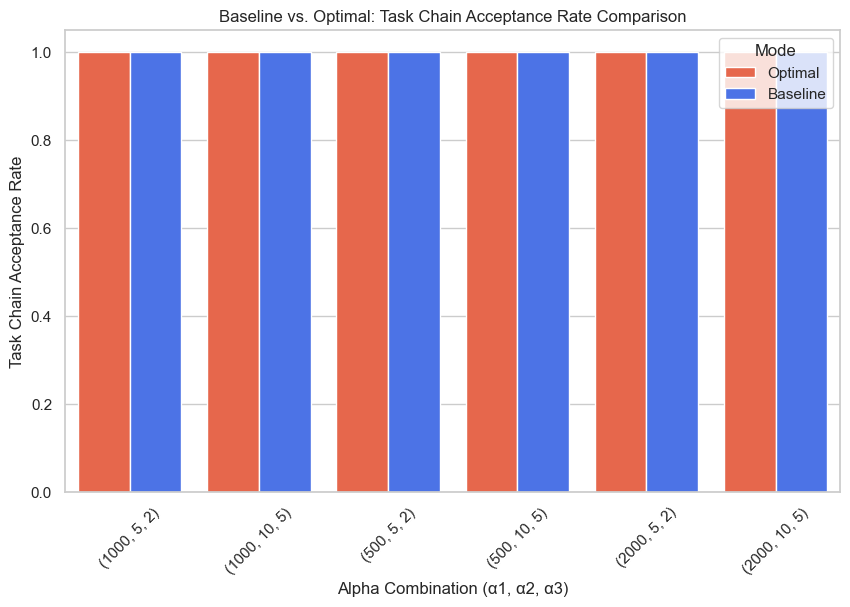

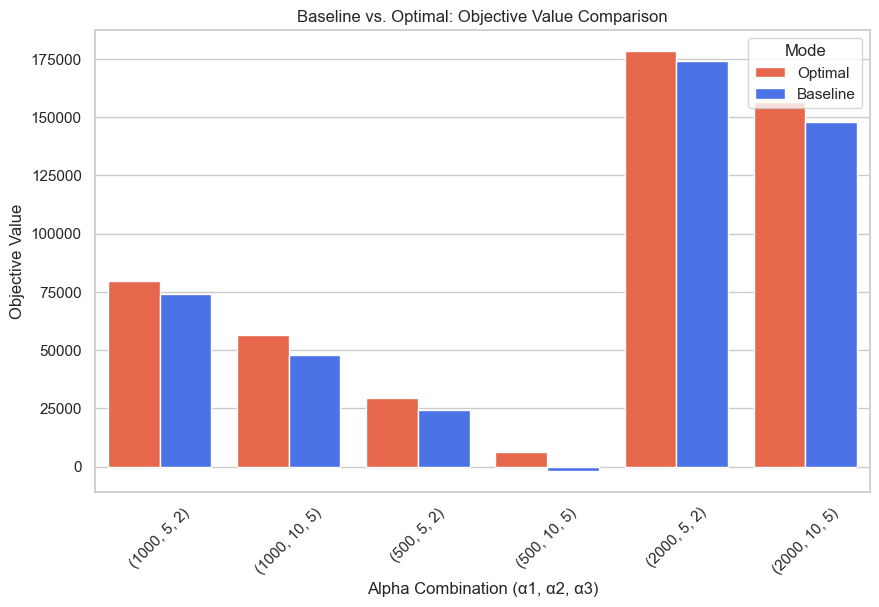

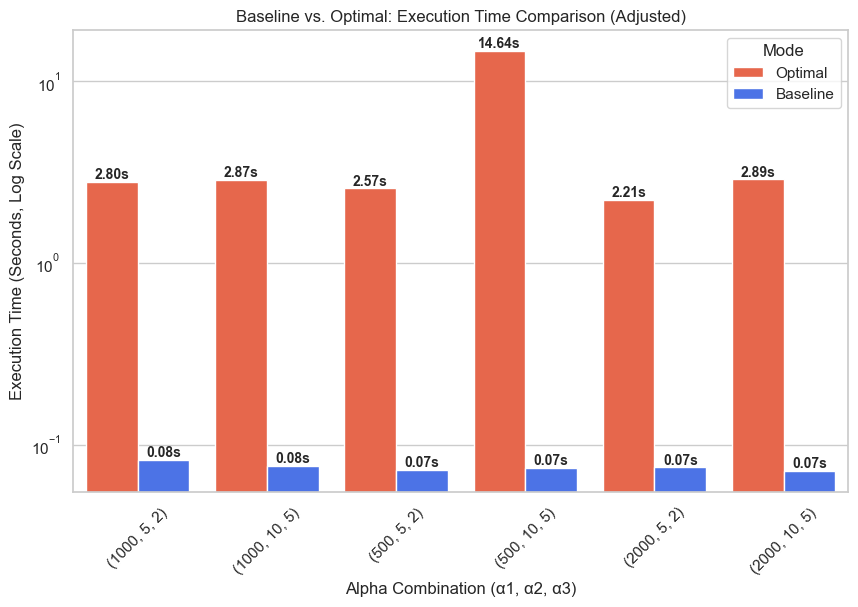

,Mode,Alpha Combination,Acceptance Rate,Total PU Energy,Objective Value,Execution Time
0,Optimal,"(1000, 5, 2)",1.0,2720.0,79560.0,2.800521
1,Baseline,"(1000, 5, 2)",1.0,380.0,74240.0,0.082318
2,Optimal,"(1000, 10, 5)",1.0,2720.0,56400.0,2.871267
3,Baseline,"(1000, 10, 5)",1.0,380.0,48100.0,0.076097
4,Optimal,"(500, 5, 2)",1.0,2720.0,29560.0,2.572481
5,Baseline,"(500, 5, 2)",1.0,380.0,24240.0,0.072791
6,Optimal,"(500, 10, 5)",1.0,2720.0,6400.0,14.636384
7,Baseline,"(500, 10, 5)",1.0,380.0,-1900.0,0.074386
8,Optimal,"(2000, 5, 2)",1.0,4847.6,178354.8,2.212444
9,Baseline,"(2000, 5, 2)",1.0,380.0,174240.0,0.074947


In [ ]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [700] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [80] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        # 计算任务链的端到端延迟（执行时间 + 通信延迟） Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        # 端到端（E2E）延迟约束（只有 `z_chain_k[k] = 1` 时生效）  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j] + (P_max[j] - P_idle[j]) * U_j[j] * T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
    return maf_energy_levels, maf_pu_assignments

optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

# calculate and store Acceptance Rate
acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
acceptance_rate_base = calculate_acceptance_rate(baseline_model)

acceptance_rates_opt.append(acceptance_rate_opt)
acceptance_rates_base.append(acceptance_rate_base)
execution_times_opt.append(execution_time_opt)
execution_times_base.append(execution_time_base)

# === Visualize MAF chain acceptance rate vs.  ===
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))

#  Acceptance Rate
ax.bar(x, [acceptance_rate_opt, acceptance_rate_base], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Comparison of MAF Chain Acceptance Rate (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
    ax.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")

plt.show()



fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))
width = 0.4  


ax.bar(x, [execution_time_opt, execution_time_base], width, color=["green", "orange"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Comparison of Algorithm Execution Time (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([execution_time_opt, execution_time_base]):
    ax.text(i, v + 0.05, f"{v:.2f}s", ha="center", fontsize=10, fontweight="bold")

plt.show()


plt.figure(figsize=(8, 5))
plt.hist([baseline_energy_levels, optimal_energy_levels], bins=np.arange(1, K + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["red", "blue"], alpha=0.7)
plt.xlabel("Energy Level")
plt.ylabel("Number of MAFs")
plt.title("MAF Energy Level Distribution (Baseline vs Optimal)")
plt.xticks(range(1, K + 1))
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist([baseline_pu_assignments, optimal_pu_assignments], bins=np.arange(1, m + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["orange", "green"], alpha=0.7)
plt.xlabel("Processing Unit")
plt.ylabel("Number of MAFs")
plt.title("MAF Task Assignment on PUs (Baseline vs Optimal)")
plt.xticks(range(1, m + 1))
plt.legend()
plt.show()



optimal_obj = optimal_model.objVal if optimal_model else float('-inf')
baseline_obj = baseline_model.objVal if baseline_model else float('-inf')

print(f"✅ Optimal Model Objective: {optimal_obj:.2f}")
print(f"✅ Baseline Model Objective: {baseline_obj:.2f}")


fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))


ax.bar(x, [optimal_obj, baseline_obj], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Model Objective")
ax.set_title("Comparison of Model Objective (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([optimal_obj, baseline_obj]):
    ax.text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.show()


# Define multiple sets of alpha values
alpha_values = [
    (1000, 5, 2),
    (1000, 10, 5),
    (500, 5, 2),
    (500, 10, 5),
    (2000, 5, 2),
    (2000, 10, 5),
]

# Store experiment results
experiment_results = []

for alpha_1, alpha_2, alpha_3 in alpha_values:
    print(f"Testing with α1={alpha_1}, α2={alpha_2}, α3={alpha_3} (Optimal & Baseline)")

    # Run Optimal model
    start_time_opt = time.perf_counter()
    optimal_model = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False)
    execution_time_opt = time.perf_counter() - start_time_opt

    # Run Baseline model
    start_time_base = time.perf_counter()
    baseline_model = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=True)
    execution_time_base = time.perf_counter() - start_time_base

    # Record experiment data
    for model, mode, exec_time in [(optimal_model, "Optimal", execution_time_opt),
                                    (baseline_model, "Baseline", execution_time_base)]:
        if model is not None:
            total_energy_PU = sum(model.getVarByName(f"E_PU[{j}]").X for j in range(m))
            acceptance_rate = calculate_acceptance_rate(model)
            objective_value = model.objVal

            experiment_results.append({
                "Mode": mode,
                "Alpha Combination": f"({alpha_1}, {alpha_2}, {alpha_3})",
                "Acceptance Rate": acceptance_rate,
                "Total PU Energy": total_energy_PU,
                "Objective Value": objective_value,
                "Execution Time": exec_time,
            })
        else:
            experiment_results.append({
                "Mode": mode,
                "Alpha Combination": f"({alpha_1}, {alpha_2}, {alpha_3})",
                "Acceptance Rate": 0,
                "Total PU Energy": float('inf'),
                "Objective Value": float('-inf'),
                "Execution Time": exec_time,
            })

# Convert results to DataFrame
df_results = pd.DataFrame(experiment_results)

# === Visualization: Optimal vs. Baseline Comparison ===

# Set plot style
sns.set(style="whitegrid")

# Define high-contrast colors
colors = ["#FF5733", "#3366FF"]  # Orange for Baseline, Blue for Optimal

# 1️⃣ Task Chain Acceptance Rate Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Alpha Combination", y="Acceptance Rate", hue="Mode", palette=colors)
plt.xlabel("Alpha Combination (α1, α2, α3)")
plt.ylabel("Task Chain Acceptance Rate")
plt.title("Baseline vs. Optimal: Task Chain Acceptance Rate Comparison")
plt.xticks(rotation=45)
plt.legend(title="Mode", loc="upper right")
plt.show()

# 3️⃣ Objective Value Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x="Alpha Combination", y="Objective Value", hue="Mode", palette=colors)
plt.xlabel("Alpha Combination (α1, α2, α3)")
plt.ylabel("Objective Value")
plt.title("Baseline vs. Optimal: Objective Value Comparison")
plt.xticks(rotation=45)
plt.legend(title="Mode", loc="upper right")
plt.show()

# 4️⃣ Execution Time Comparison (Log Scale for Visibility)
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_results, x="Alpha Combination", y="Execution Time", hue="Mode", palette=colors)
plt.xlabel("Alpha Combination (α1, α2, α3)")
plt.ylabel("Execution Time (Seconds, Log Scale)")
plt.title("Baseline vs. Optimal: Execution Time Comparison (Adjusted)")

# Convert Y-axis to Log Scale (fix small values issue)
plt.yscale("log")

# Annotate bars with actual execution times
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.2f}s",
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, fontweight="bold")

plt.xticks(rotation=45)
plt.legend(title="Mode", loc="upper right")
plt.show()

# Display experiment results table
display(df_results)







## **1. Decision Variables**
$$
\begin{aligned}
\delta_i &\quad \text{Binary, 1 if MAF task } i \text{ is active, 0 otherwise} \\
w_{i,j} &\quad \text{Binary, 1 if task } i \text{ is assigned to PU } j, \text{ 0 otherwise} \\
y_{i,k} &\quad \text{Binary, 1 if task } i \text{ operates at energy level } k, \text{ 0 otherwise} \\
E_{\text{PU},j} &\quad \text{Total energy consumption of PU } j \\
U_j &\quad \text{PU } j \text{ utilization level} \\
z_k &\quad \text{Binary, 1 if task chain } k \text{ is accepted, 0 otherwise}
\end{aligned}
$$

## **2. Objective Function**
$$
\max F = \alpha_1 \sum_{i=1}^{n} \delta_i - \alpha_2 \sum_{i=1}^{n} E_{i,K_i} - \alpha_{\text{PU}} \sum_{j=1}^{m} E_{\text{PU},j}
$$

## **3. Constraints**
### **1. End-to-End (E2E) Latency for Task Chains**
$$
\sum_{i \in C_k} L_{i, K_i} + \sum_{(i,j) \in C_k} L_{\text{comm},(i,j)} \leq L_{\text{max}, k}, \quad \forall k
$$

### **2. Task Assignment to a Single PU**
$$
\sum_{j=1}^{m} w_{i,j} = \delta_i, \quad \forall i
$$

### **3. Single Energy Level Selection per Task**
$$
\sum_{k=1}^{|K|} y_{i,k} = 1, \quad \forall i
$$

### **4. PU Computational Capacity Constraint**
$$
\sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i} \leq C_{\text{PU},j}, \quad \forall j
$$

### **5. Task Execution Time Dependency on PU Utilization**
$$
U_j = \frac{\sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i}}{T_{\text{total}}}, \quad \forall j
$$

### **6. PU Energy Consumption Model**
$$
E_{\text{PU},j} = P_{\text{idle},j} \cdot \left(T_{\text{total}} - \sum_{i=1}^{n} w_{i,j} \cdot L_{i,K_i} \right) + (P_{\text{max},j} - P_{\text{idle},j}) \cdot U_j \cdot T_{\text{total}}, \quad \forall j
$$

### **7. PU Energy Consumption Limit**
$$
E_{\text{PU},j} \leq E_{\text{PU},\max}, \quad \forall j
$$












# **Comparison: Dynamic PU Energy Calculation vs DVFS**

## **1️⃣ Optimization Method**
- **Dynamic PU Energy Calculation**: Based on **PU utilization** $ U_j $.
- **DVFS**: Adjusts **PU frequency** $ F_j $ and **voltage** $ V_j $.

---

## **2️⃣ Energy Consumption Formula**
- **Dynamic PU Energy Calculation**:  
  $$ E_{\text{PU},j} = P_{\text{idle},j} + (P_{\text{max},j} - P_{\text{idle},j}) \cdot U_j \cdot T_{\text{total}} $$
- **DVFS**:  
  $$ E_{\text{PU},j} = C_j V_j^2 F_j D_{i,K_i} $$

---

## **3️⃣ Impact of PU Utilization**
- **Dynamic PU Energy Calculation**: **High PU utilization** $ U_j $ increases power consumption, **idle PU consumes less**.
- **DVFS**: Adjusts $ F_j $ and $ V_j $ to **keep power low even under high utilization**.

---

## **4️⃣ Impact on Task Execution Time**
- **Dynamic PU Energy Calculation**: **Execution time is constant**, only affects PU utilization.
- **DVFS**: **Lower $ F_j $ increases task execution time**.

---

## **5️⃣ Applicable Scenarios**
- **Dynamic PU Energy Calculation**: **Cloud computing, edge computing, task scheduling**.
- **DVFS**: **Embedded systems, mobile devices, low-power computing**.

---

## **6️⃣ Constraint Complexity**
- **Dynamic PU Energy Calculation**: Requires **PU utilization calculation**, no hardware voltage limitations.
- **DVFS**: Requires **hardware support for DVFS**, and frequency adjustments.

---

## **7️⃣ Task Scheduling Flexibility**
- **Dynamic PU Energy Calculation**: Tasks **can migrate dynamically**; PU load **adjusts automatically**.
- **DVFS**: **Frequency adjustments may affect scheduling**, some tasks require a fixed frequency.

---

## **📌 Literature Sources**
- **Dynamic PU Energy Calculation**: Energy-aware task scheduling for heterogeneous cloud computing systems Mishra, A., & Sahoo, B. (2015)
---
- **DVFS**: A Dynamic Voltage Scaling Algorithm for Power-aware Real-time Systems Yao, F., Demers, A., & Shenker, S. (1995)






In [ ]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
from IPython.display import display

# === Problem Setup ===
n = 100  # Number of MAFs (tasks)
m = 10  # Number of processing units
K = 5  # Number of energy levels

L_levels = [5, 3, 1.5, 0.7, 0.2]  # Delay per energy level
E_levels = [10, 20, 30, 40, 50]   # Energy consumption per energy class
E_PU_max = [500] * m  # Maximum energy consumption per processing unit
CPU_capacity = [700] * m  # CPU resources per processing unit
f_v_levels = [5, 10, 20, 30, 65]  # CPU requirements for each MAF
C_total_max = 10000  # Total system resource capacity
P_idle = [2] * m  # Idle power consumption per PU
T_total = 300  # Total system execution time
P_max = [20] * m  # PU Full-load power consumption
# Task Chains
num_chains = 10
chain_tasks = {i: list(range(i * 10, (i + 1) * 10)) for i in range(num_chains)}
L_max = [80] * num_chains 


def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 300
    model.Params.MIPGap = 0.05
    model.Params.MIPFocus = 1
    model.Params.Presolve = 2
    model.Params.Method = 2
    model.Params.Threads = 8

def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False):
    model = Model("MAF_Model")
    configure_model(model)

    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    E_PU = model.addVars(m, vtype=GRB.CONTINUOUS, name="E_PU")
    z_chain_k = model.addVars(num_chains, vtype=GRB.BINARY, name="z_chain_k")  
    U_j = model.addVars(m, vtype=GRB.CONTINUOUS, name="U")

    for k in range(num_chains):
        chain = chain_tasks[k]
        
        # Task chain `k` failure logic: if any `delta[i] = 0` within `chain_tasks[k]`, then `z_chain_k[k] = 0`.
        for i in chain:
            model.addConstr(z_chain_k[k] <= delta[i], name=f"ChainActivation_{k}_Task_{i}")

        # 计算任务链的端到端延迟（执行时间 + 通信延迟） Calculation of end-to-end delay in the task chain (execution time + communication delay)
        execution_time_sum = quicksum(quicksum(y[i, e] * L_levels[e] for e in range(K)) for i in chain)
        communication_delay =  len(chain) - 1  

        # 端到端（E2E）延迟约束（只有 `z_chain_k[k] = 1` 时生效）  End-to-end (E2E) delay constraints (effective only if `z_chain_k[k] = 1`)
        model.addConstr(
            execution_time_sum + communication_delay <= L_max[k] * z_chain_k[k] + (1 - z_chain_k[k]) * 1e-6,
            name=f"EndToEndLatency_Chain_{k}"
        )

    # mafs constraints
    for i in range(n):
        model.addConstr(quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(quicksum(y[i, e] for e in range(K)) == delta[i])

    # Limiting PU resources
    for j in range(m):
        execution_time = quicksum(w[i, j] * quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        model.addConstr(U_j[j] == execution_time / T_total)
        model.addConstr(E_PU[j] == P_idle[j] + (P_max[j] - P_idle[j]) * U_j[j] * T_total)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    for j in range(m):
        model.addConstr(
            quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n)) <= CPU_capacity[j]
        )

    model.addConstr(
        quicksum(w[i, j] * quicksum(f_v_levels[e] * y[i, e] for e in range(K)) for i in range(n) for j in range(m)) <= C_total_max
    )

    # Baseline only modifies the energy level selection logic, other constraints are consistent with Optimal.
    if baseline:
        model.addConstrs((y[i, K-1] == delta[i] for i in range(n)), name="BaselineMaxEnergy")

    obj = (
        alpha_1 * quicksum(delta[i] for i in range(n))
        - alpha_2 * quicksum(y[i, e] * E_levels[e] for i in range(n) for e in range(K))
        - alpha_3 * quicksum(E_PU[j] for j in range(m))
    )

    model.setObjective(obj, GRB.MAXIMIZE)
    model.optimize()
    return model if model.status == GRB.OPTIMAL else None


# === Run Baseline and Optimal and measure the execution time.  ===
execution_times_opt = []
execution_times_base = []
acceptance_rates_opt = []
acceptance_rates_base = []


# Running the Optimal model
start_time_opt = time.perf_counter()
optimal_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=False)
execution_time_opt = time.perf_counter() - start_time_opt

# Running the Baseline Model
start_time_base = time.perf_counter()
baseline_model = run_gurobi_model(alpha_1=1000, alpha_2=3, alpha_3=2, baseline=True)
execution_time_base = time.perf_counter() - start_time_base

def extract_results(model):
    maf_energy_levels = np.zeros(n, dtype=int)
    maf_pu_assignments = np.zeros(n, dtype=int)
    if model is None:
        return maf_energy_levels, maf_pu_assignments
    for i in range(n):
        for e in range(K):
            var_name = f"y[{i},{e}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_energy_levels[i] = e + 1
        for j in range(m):
            var_name = f"w[{i},{j}]"
            var = model.getVarByName(var_name)
            if var is not None and var.x > 0.5:
                maf_pu_assignments[i] = j + 1
    return maf_energy_levels, maf_pu_assignments

optimal_energy_levels, optimal_pu_assignments = extract_results(optimal_model)
baseline_energy_levels, baseline_pu_assignments = extract_results(baseline_model)


# === MAF Chain Acceptance Rate ===
def calculate_acceptance_rate(model):
    if model is None:
        return 0  #
    
    accepted_chains = sum(1 for k in range(num_chains) if model.getVarByName(f"z_chain_k[{k}]").X > 0.5)
    return accepted_chains / num_chains  # 

# calculate and store Acceptance Rate
acceptance_rate_opt = calculate_acceptance_rate(optimal_model)
acceptance_rate_base = calculate_acceptance_rate(baseline_model)

acceptance_rates_opt.append(acceptance_rate_opt)
acceptance_rates_base.append(acceptance_rate_base)
execution_times_opt.append(execution_time_opt)
execution_times_base.append(execution_time_base)

# === Visualize MAF chain acceptance rate vs.  ===
fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))

#  Acceptance Rate
ax.bar(x, [acceptance_rate_opt, acceptance_rate_base], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Comparison of MAF Chain Acceptance Rate (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
for i, v in enumerate([acceptance_rate_opt, acceptance_rate_base]):
    ax.text(i, v + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")

plt.show()



fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))
width = 0.4  


ax.bar(x, [execution_time_opt, execution_time_base], width, color=["green", "orange"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Comparison of Algorithm Execution Time (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([execution_time_opt, execution_time_base]):
    ax.text(i, v + 0.05, f"{v:.2f}s", ha="center", fontsize=10, fontweight="bold")

plt.show()


plt.figure(figsize=(8, 5))
plt.hist([baseline_energy_levels, optimal_energy_levels], bins=np.arange(1, K + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["red", "blue"], alpha=0.7)
plt.xlabel("Energy Level")
plt.ylabel("Number of MAFs")
plt.title("MAF Energy Level Distribution (Baseline vs Optimal)")
plt.xticks(range(1, K + 1))
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.hist([baseline_pu_assignments, optimal_pu_assignments], bins=np.arange(1, m + 2) - 0.5, 
         label=["Baseline", "Optimal"], color=["orange", "green"], alpha=0.7)
plt.xlabel("Processing Unit")
plt.ylabel("Number of MAFs")
plt.title("MAF Task Assignment on PUs (Baseline vs Optimal)")
plt.xticks(range(1, m + 1))
plt.legend()
plt.show()



optimal_obj = optimal_model.objVal if optimal_model else float('-inf')
baseline_obj = baseline_model.objVal if baseline_model else float('-inf')

print(f"✅ Optimal Model Objective: {optimal_obj:.2f}")
print(f"✅ Baseline Model Objective: {baseline_obj:.2f}")


fig, ax = plt.subplots(figsize=(8, 5))
x_labels = ["Optimal", "Baseline"]
x = np.arange(len(x_labels))


ax.bar(x, [optimal_obj, baseline_obj], width=0.4, color=["blue", "red"], alpha=0.8)


ax.set_xlabel("Algorithm")
ax.set_ylabel("Model Objective")
ax.set_title("Comparison of Model Objective (Optimal vs Baseline)")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)


for i, v in enumerate([optimal_obj, baseline_obj]):
    ax.text(i, v + 5, f"{v:.2f}", ha="center", fontsize=10, fontweight="bold")

plt.show()